Episode 0 | Total Reward: 0.57 | Total Fitness: 0.82 | Total Distance: 1684.31 | Total Time: 2089.87 | Total Success: 0.83
Episode 1 | Total Reward: 0.58 | Total Fitness: 0.84 | Total Distance: 2025.36 | Total Time: 2031.22 | Total Success: 0.85
Episode 2 | Total Reward: 0.33 | Total Fitness: 0.74 | Total Distance: 2386.41 | Total Time: 2738.19 | Total Success: 0.72
Episode 3 | Total Reward: 0.44 | Total Fitness: 0.80 | Total Distance: 2277.91 | Total Time: 2484.79 | Total Success: 0.78
Episode 4 | Total Reward: 0.56 | Total Fitness: 0.83 | Total Distance: 2084.87 | Total Time: 2363.31 | Total Success: 0.83
Episode 5 | Total Reward: 0.74 | Total Fitness: 0.92 | Total Distance: 1760.76 | Total Time: 1712.08 | Total Success: 0.93
Episode 6 | Total Reward: 0.56 | Total Fitness: 0.82 | Total Distance: 2080.07 | Total Time: 2227.11 | Total Success: 0.83
Episode 7 | Total Reward: 0.52 | Total Fitness: 0.84 | Total Distance: 1943.68 | Total Time: 2017.64 | Total Success: 0.81
Episode 8 | Tota

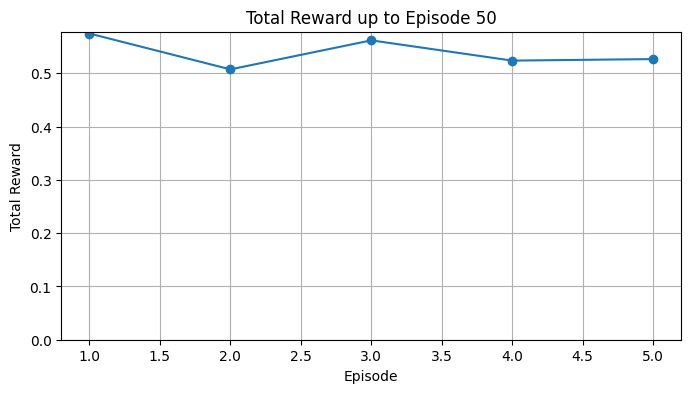

Episode 50 | Total Reward: 0.55 | Total Fitness: 0.85 | Total Distance: 2080.41 | Total Time: 2444.56 | Total Success: 0.83
Episode 51 | Total Reward: 0.50 | Total Fitness: 0.80 | Total Distance: 1948.48 | Total Time: 2320.30 | Total Success: 0.81
Episode 52 | Total Reward: 0.57 | Total Fitness: 0.87 | Total Distance: 1864.64 | Total Time: 2011.21 | Total Success: 0.83
Episode 53 | Total Reward: 0.46 | Total Fitness: 0.80 | Total Distance: 2044.12 | Total Time: 2283.85 | Total Success: 0.78
Episode 54 | Total Reward: 0.39 | Total Fitness: 0.83 | Total Distance: 2297.00 | Total Time: 2555.32 | Total Success: 0.75
Episode 55 | Total Reward: 0.45 | Total Fitness: 0.77 | Total Distance: 2378.16 | Total Time: 2320.95 | Total Success: 0.78
Episode 56 | Total Reward: 0.46 | Total Fitness: 0.83 | Total Distance: 2053.25 | Total Time: 2349.70 | Total Success: 0.78
Episode 57 | Total Reward: 0.44 | Total Fitness: 0.79 | Total Distance: 2234.67 | Total Time: 2709.62 | Total Success: 0.78
Episode 

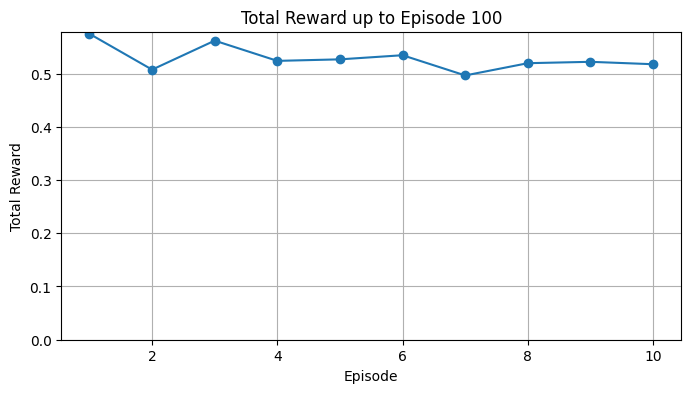

Episode 100 | Total Reward: 0.67 | Total Fitness: 0.88 | Total Distance: 1980.03 | Total Time: 2121.80 | Total Success: 0.89
Episode 101 | Total Reward: 0.44 | Total Fitness: 0.77 | Total Distance: 2063.91 | Total Time: 2647.10 | Total Success: 0.78
Episode 102 | Total Reward: 0.51 | Total Fitness: 0.77 | Total Distance: 1909.19 | Total Time: 2250.17 | Total Success: 0.81
Episode 103 | Total Reward: 0.67 | Total Fitness: 0.92 | Total Distance: 2029.32 | Total Time: 2169.61 | Total Success: 0.89
Episode 104 | Total Reward: 0.50 | Total Fitness: 0.83 | Total Distance: 2015.11 | Total Time: 2415.84 | Total Success: 0.81
Episode 105 | Total Reward: 0.56 | Total Fitness: 0.90 | Total Distance: 2001.70 | Total Time: 2313.56 | Total Success: 0.83
Episode 106 | Total Reward: 0.51 | Total Fitness: 0.88 | Total Distance: 2047.90 | Total Time: 2236.33 | Total Success: 0.81
Episode 107 | Total Reward: 0.50 | Total Fitness: 0.88 | Total Distance: 2030.30 | Total Time: 2467.57 | Total Success: 0.81


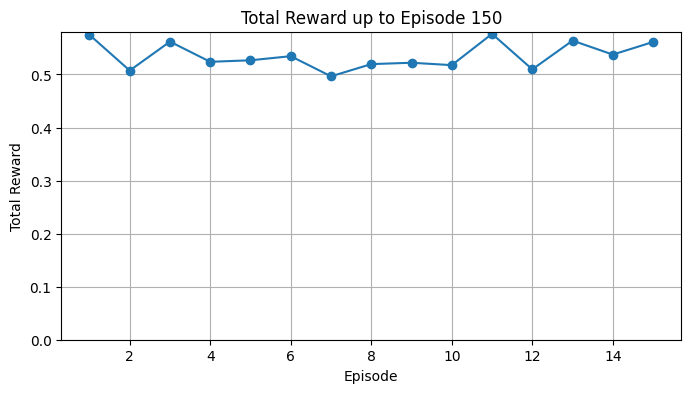

KeyboardInterrupt: 

In [ ]:
min_scale = 5
middle_scale = 10
max_scale = 20

# from serial.main import train_maddpg
# train_maddpg(middle_scale, episodes=1000)

# from parallel.main import train_maddpg
# train_maddpg(middle_scale, episodes=1000)

# from contract.main import run_cnp
# run_cnp(scale=middle_scale, episodes=50)

from mappo.main import train_mappo
train_mappo(scale=middle_scale, episodes=1000)